In [ ]:
# Install Prophet
!pip install prophet

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels for ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Prophet
from prophet import Prophet

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Load dataset (AirPassengers.csv available on Kaggle)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)

df.head()


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Rename column for Prophet compatibility
df.rename(columns={'Passengers': 'y'}, inplace=True)
df['ds'] = df.index

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       144 non-null    int64         
 1   ds      144 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.4 KB
None


,y,ds
Month,,
1949-01-01,112,1949-01-01
1949-02-01,118,1949-02-01
1949-03-01,132,1949-03-01
1949-04-01,129,1949-04-01
1949-05-01,121,1949-05-01


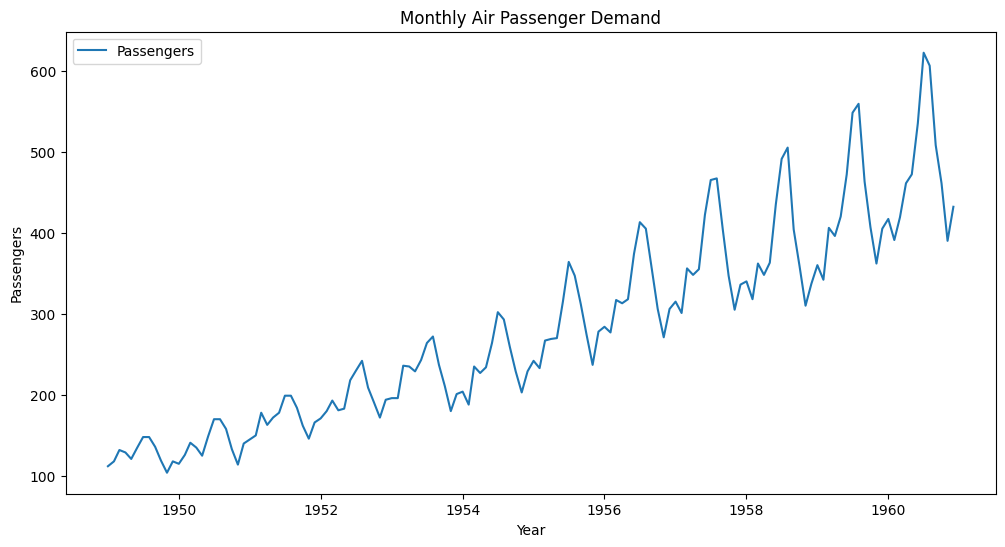

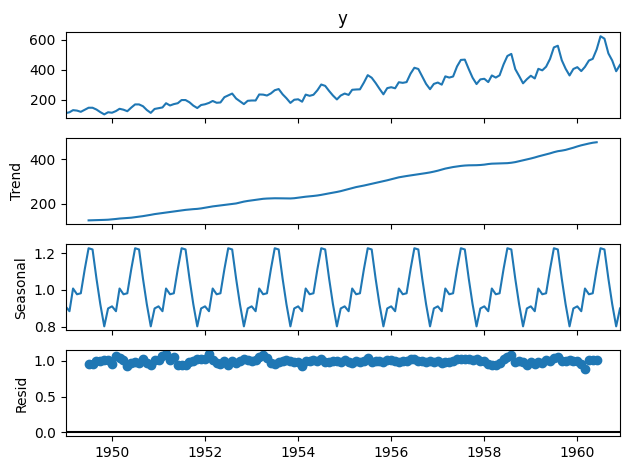

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['y'], label="Passengers")
plt.title("Monthly Air Passenger Demand")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.show()

# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['y'], model='multiplicative', period=12)
decomposition.plot()
plt.show()


In [ ]:
result = adfuller(df['y'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


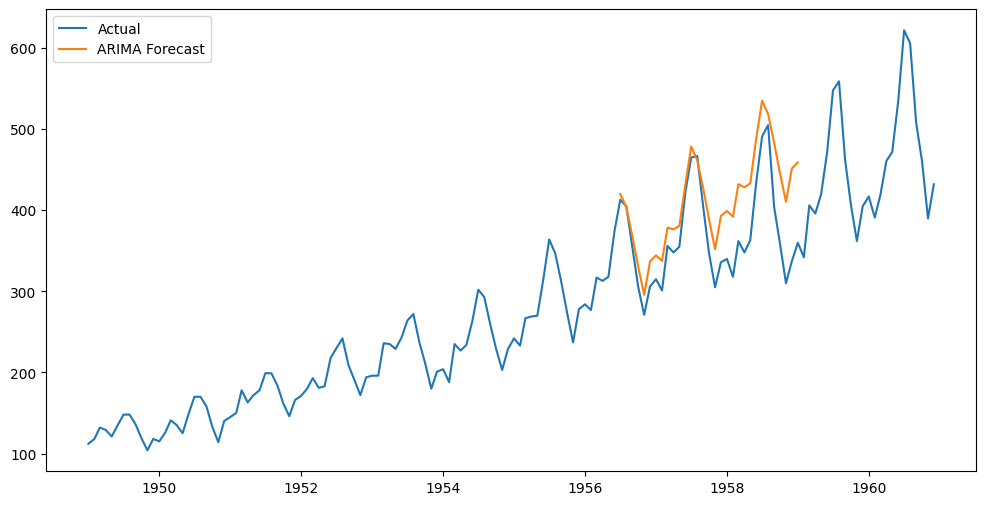

In [ ]:
# SARIMA (seasonal ARIMA)
model = sm.tsa.statespace.SARIMAX(df['y'],
                                  order=(1,1,1),
                                  seasonal_order=(1,1,1,12))
results = model.fit()
df['forecast_arima'] = results.predict(start=90, end=120, dynamic=True)

plt.figure(figsize=(12,6))
plt.plot(df['y'], label="Actual")
plt.plot(df['forecast_arima'], label="ARIMA Forecast")
plt.legend()
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi0n45872/89f6oelv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi0n45872/e7vzyd0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47455', 'data', 'file=/tmp/tmpi0n45872/89f6oelv.json', 'init=/tmp/tmpi0n45872/e7vzyd0f.json', 'output', 'file=/tmp/tmpi0n45872/prophet_model5equvtmk/prophet_model-20250831081904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:19:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


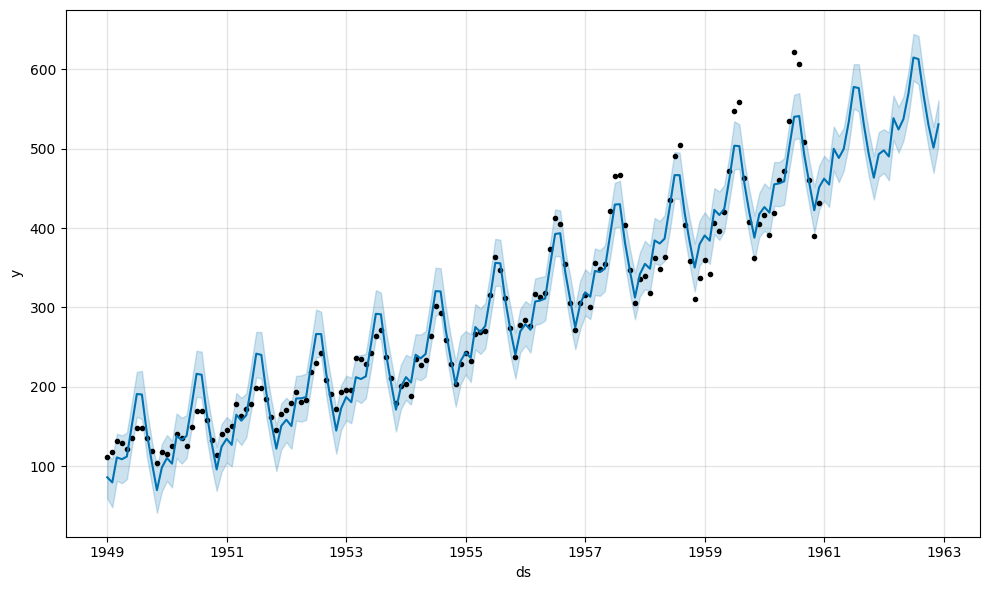

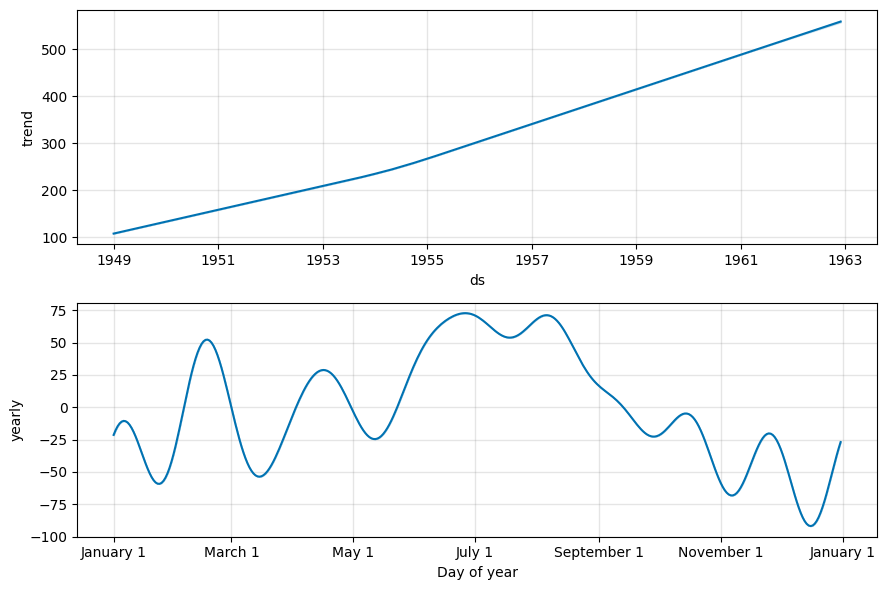

In [ ]:
m = Prophet(yearly_seasonality=True)
m.fit(df[['ds','y']])

future = m.make_future_dataframe(periods=24, freq='M')
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df['y'].values.reshape(-1,1))

# Create sequences
X, y = [], []
time_step = 12
for i in range(len(scaled)-time_step-1):
    X.append(scaled[i:(i+time_step),0])
    y.append(scaled[i+time_step,0])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

# Train
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=16, verbose=1)

# Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.0982 - val_loss: 0.0777
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0167 - val_loss: 0.0221
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0141 - val_loss: 0.0384
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0116 - val_loss: 0.0431
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0086 - val_loss: 0.0222
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0077 - val_loss: 0.0209
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0067 - val_loss: 0.0258
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0075 - val_loss: 0.0209
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0071 - val_loss: 0.0205
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0070 - val_loss: 0.0205
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0058 - val_loss: 0.0209
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0087 - val_loss: 0.0211

In [ ]:
# ARIMA
arima_eval = df[['y','forecast_arima']].dropna()
arima_rmse = np.sqrt(mean_squared_error(arima_eval['y'], arima_eval['forecast_arima']))

# Prophet
prophet_eval = forecast[:len(df)]
prophet_rmse = np.sqrt(mean_squared_error(df['y'], prophet_eval['yhat']))

# LSTM
lstm_rmse = np.sqrt(mean_squared_error(df['y'][-len(test_pred):], test_pred))

print("ARIMA RMSE:", arima_rmse)
print("Prophet RMSE:", prophet_rmse)
print("LSTM RMSE:", lstm_rmse)


ARIMA RMSE: 54.41031995524187
Prophet RMSE: 22.430335659922022
LSTM RMSE: 59.02515560454394


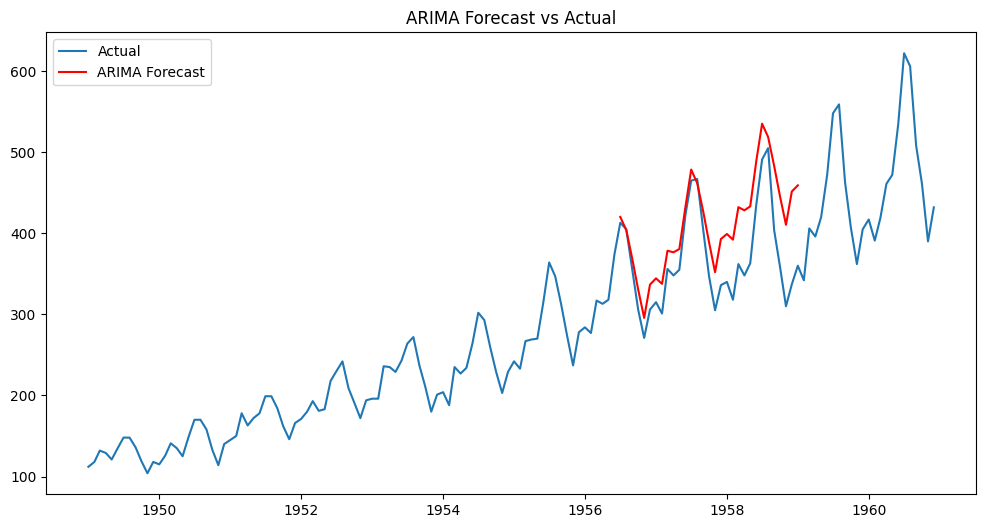

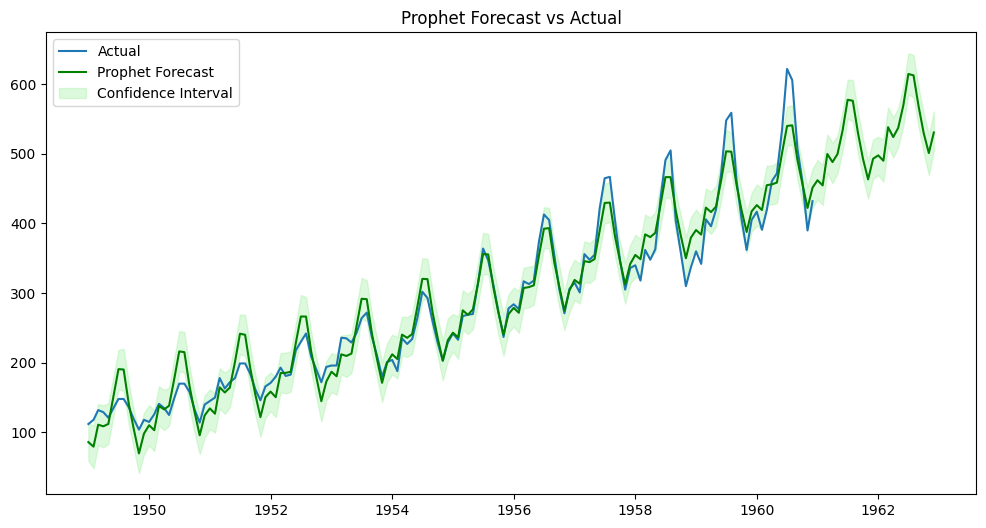

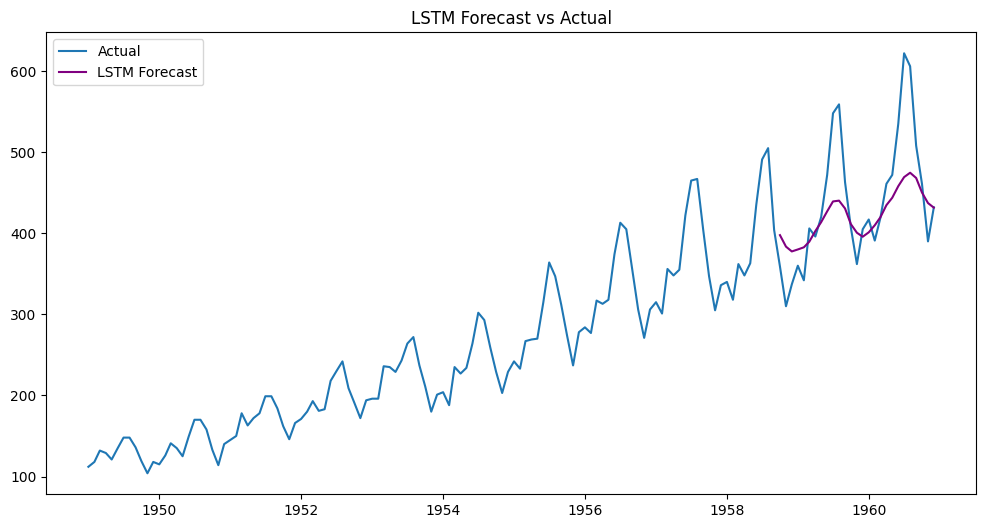

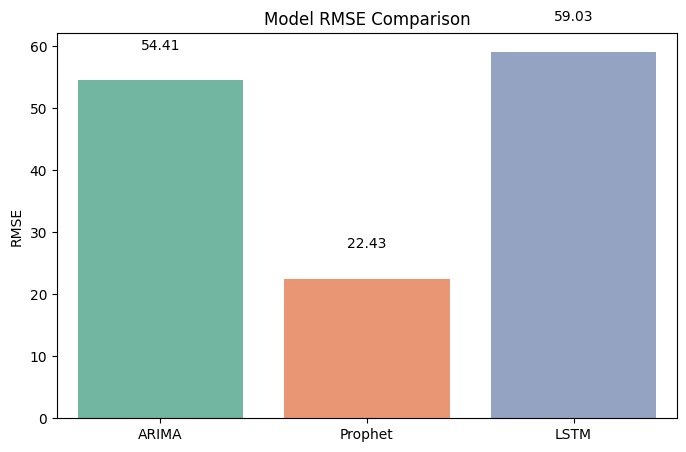

In [ ]:
# ARIMA Plot
plt.figure(figsize=(12,6))
plt.plot(df['y'], label="Actual")
plt.plot(df['forecast_arima'], label="ARIMA Forecast", color="red")
plt.legend(); plt.title("ARIMA Forecast vs Actual"); plt.show()

# Prophet Plot
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label="Actual")
plt.plot(forecast['ds'], forecast['yhat'], label="Prophet Forecast", color="green")
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 alpha=0.3, color="lightgreen", label="Confidence Interval")
plt.legend(); plt.title("Prophet Forecast vs Actual"); plt.show()

# LSTM Plot
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label="Actual")
plt.plot(df['ds'][-len(test_pred):], test_pred, label="LSTM Forecast", color="purple")
plt.legend(); plt.title("LSTM Forecast vs Actual"); plt.show()

# RMSE Comparison
models = ["ARIMA", "Prophet", "LSTM"]
rmse_values = [arima_rmse, prophet_rmse, lstm_rmse]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=rmse_values, palette="Set2")
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
for i, v in enumerate(rmse_values):
    plt.text(i, v + 5, f"{v:.2f}", ha='center')
plt.show()
